In [18]:
import pandas as pd
import scipy.sparse as sp
import numpy as np
import implicit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [53]:
file = "data_100.csv"
df = pd.read_csv(file)
df.head()

,user_id,item_id,score
0,ABX,0dBJIkp7qIg,9
1,ABX,0Q6dVt8Oteo,2
2,ABX,0XPRVXqK3S8,9
3,ABX,1ltrfBue6Xk,9
4,ABX,1VIJn67HpaU,9


In [54]:
# Get unique usernames and videos
users = df['user_id'].unique()
videos = df['item_id'].unique()

print(len(users))
print(len(videos))

# Create an empty matrix
matrix = pd.DataFrame(index=users, columns=videos)


# Fill in matrix with scores
for i, row in df.iterrows():
    matrix.loc[row['user_id'], row['item_id']] = row['score']
    
matrix = matrix.fillna(0)
# Print matrix
print(matrix)


58
11788
                     0dBJIkp7qIg  0Q6dVt8Oteo  0XPRVXqK3S8  1ltrfBue6Xk  \
ABX                            9            2            9            9   
aidjango                       0            0            9            0   
alexandrerfst                  0            0            0            0   
Amaresh                        0            0            0            0   
amatissart                     0            0            0            0   
AntoineJ                       0            0            0            0   
Antoine_Jamelot                0            0            0            0   
Arthur                         0            0            0            0   
bastianlouis                   0            0            0            0   
Bertrand Seguy                 0            0            0            0   
biscuissec                     0            0            9            0   
CB                             0            0            0            0   
DexterIzzie     

In [55]:
# Create a dictionary to map usernames to user ids
user_dict = {user_id: i for i, user_id in enumerate(df['user_id'].unique())}

print(user_dict)

# Create a dictionary to map videos to item ids
item_dict = {item_id: i for i, item_id in enumerate(df['item_id'].unique())}

# Create an empty matrix for scores
num_users = len(user_dict)
num_items = len(item_dict)
scores = np.empty((num_users, num_items), dtype=np.float32)
scores.fill(np.nan)


# Fill in matrix with scores
for i, row in df.iterrows():
    user_id = user_dict[row['user_id']]
    item_id = item_dict[row['item_id']]
    score = row['score']
    scores[user_id, item_id] = score

print(scores)


{'ABX': 0, 'aidjango': 1, 'alexandrerfst': 2, 'Amaresh': 3, 'amatissart': 4, 'AntoineJ': 5, 'Antoine_Jamelot': 6, 'Arthur': 7, 'bastianlouis': 8, 'Bertrand Seguy': 9, 'biscuissec': 10, 'CB': 11, 'DexterIzzie': 12, 'DimLight12': 13, 'Dorsan': 14, 'emmanuel.chambost': 15, 'Everyatis': 16, 'FalafelAuxCarottes': 17, 'F.Marchal-Bornert': 18, 'Foebus': 19, 'from_france': 20, 'Fungus-Bob': 21, 'gbreteau': 22, 'Guigui220D': 23, 'Guillaume': 24, 'Helios-火リオス': 25, 'Intégralecurviligne': 26, 'joleenj': 27, 'jrmouraz': 28, 'Jumo004': 29, 'KronosIII': 30, 'LautreFrançois': 31, 'leDéfaillant': 32, 'le_science4all': 33, 'Loulalie': 34, 'lpfaucon': 35, 'Marlene': 36, 'megaLUS13': 37, 'MiaAnge': 38, 'mserranorichez': 39, 'Mutre': 40, 'NatNgs': 41, 'Pardel': 42, 'pedro_rouge': 43, 'Pierre M': 44, 'Riri': 45, 'samuelnihoul1': 46, 'Sciencecool': 47, 'strangery': 48, 'tesseract': 49, 'thib': 50, 'ThugFou': 51, 'tl': 52, 'umzhefmibqevkjnslj': 53, 'user7123': 54, 'wareita': 55, 'white': 56, 'Zekk': 57}
[[ 9

In [56]:
# Fill NaN values with zeros
scores = np.nan_to_num(scores, nan=0.0)
print(scores)

[[9. 2. 9. ... 0. 0. 0.]
 [0. 0. 9. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 9. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 9. ... 2. 1. 9.]]


In [11]:
from scipy.sparse import csr_matrix

def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy sparse csr_matrix
        Interactions between users and items.
        
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
        
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note the ordering
    train = ratings.copy().tocoo()
    test = csr_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(ratings.getrow(user).indices, 
                                            size=split_count, 
                                            replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = ratings[user, test_interactions]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [57]:
# Transpose the matrix to get an item-user interaction matrix
#item_user_matrix = scores.T

# Convert the transposed matrix to a sparse CSR matrix
item_user_data = sp.csr_matrix(scores)

train_item_user_data, test_item_user_data, user_index = train_test_split(item_user_data, 0, fraction=0.2)

In [16]:
from sklearn.model_selection import ParameterGrid
from implicit.evaluation import precision_at_k
from implicit.als import AlternatingLeastSquares

param_grid = {
    'factors': [100, 200, 300],
    'regularization': [0.01, 0.1, 1.0],
    'iterations': [20, 40, 60]
}

# Initialize variables to store the best parameters and the best precision
best_params = None
best_precision = 0.0

for params in ParameterGrid(param_grid):
    # Initialize ALS model with the current parameters
    model = AlternatingLeastSquares(
        factors=params['factors'],
        regularization=params['regularization'],
        iterations=params['iterations']
    )
    
    # Fit the model to the training interaction matrix
    model.fit(train_item_user_data)
    
    # Evaluate the model using precision at K
    precision = precision_at_k(model, train_item_user_data, test_item_user_data, K=5)
    
    # Print the parameters and precision for reference
    print(params, precision)
    
    # Update the best parameters if the current precision is higher
    if precision > best_precision:
        best_params = params
        best_precision = precision

# Print the best parameters and precision
print("Best Parameters:", best_params)
print("Best Precision:", best_precision)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 20, 'regularization': 0.01} 0.02702702702702703


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 20, 'regularization': 0.1} 0.04594594594594595


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 20, 'regularization': 1.0} 0.03513513513513514


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 40, 'regularization': 0.01} 0.032432432432432434


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 40, 'regularization': 0.1} 0.043243243243243246


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 40, 'regularization': 1.0} 0.03783783783783784


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 60, 'regularization': 0.01} 0.03513513513513514


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 60, 'regularization': 0.1} 0.04054054054054054


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 100, 'iterations': 60, 'regularization': 1.0} 0.04054054054054054


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 20, 'regularization': 0.01} 0.021621621621621623


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 20, 'regularization': 0.1} 0.021621621621621623


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 20, 'regularization': 1.0} 0.021621621621621623


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 40, 'regularization': 0.01} 0.021621621621621623


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 40, 'regularization': 0.1} 0.021621621621621623


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 40, 'regularization': 1.0} 0.01891891891891892


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 60, 'regularization': 0.01} 0.021621621621621623


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 60, 'regularization': 0.1} 0.024324324324324326


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 200, 'iterations': 60, 'regularization': 1.0} 0.024324324324324326


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 20, 'regularization': 0.01} 0.008108108108108109


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 20, 'regularization': 0.1} 0.008108108108108109


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 20, 'regularization': 1.0} 0.016216216216216217


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 40, 'regularization': 0.01} 0.010810810810810811


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 40, 'regularization': 0.1} 0.008108108108108109


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 40, 'regularization': 1.0} 0.013513513513513514


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 60, 'regularization': 0.01} 0.008108108108108109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 60, 'regularization': 0.1} 0.008108108108108109


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

{'factors': 300, 'iterations': 60, 'regularization': 1.0} 0.021621621621621623
Best Parameters: {'factors': 100, 'iterations': 20, 'regularization': 0.1}
Best Precision: 0.04594594594594595


In [58]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20)
    
# Fit the model to the interaction matrix
model.fit(item_user_data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [59]:
# Get recommendations for a user
userid = 3
recommended = model.recommend(userid, user_items=item_user_data[userid])

actual_ratings = []
predicted_ratings = []

for item_id in recommended[0]:
    # Find the corresponding score in the data DataFrame
    # Find the index of the user_id in the user_dict values
    index = list(item_dict.values()).index(item_id)

    # Get the corresponding user_id based on the index
    found_item = list(item_dict.keys())[index]
    data_score = df.loc[df['item_id'] == found_item, 'score'].iloc[0]
    # Find the corresponding score in the recommended list
    recommended_index = np.where(recommended[0] == item_id)[0]
    recommended_score = recommended[1][recommended_index][0] * 10
    actual_ratings.append(data_score)
    predicted_ratings.append(recommended_score)

    
#Compute evaluation metrics

mae = mean_absolute_error(actual_ratings, predicted_ratings)
rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

#0
# MAE: 4.012636426091194
# RMSE: 4.725825592884201

#10
# MAE: 3.9983141899108885
# RMSE: 4.537728760679054

#60
# MAE: 4.425096625089646
# RMSE: 4.995821837909834

#100
# MAE: 7.671800601482391
# RMSE: 8.038321883551674

MAE: 7.671800601482391
RMSE: 8.038321883551674


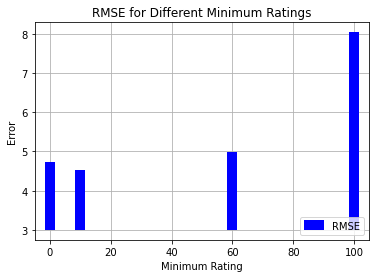

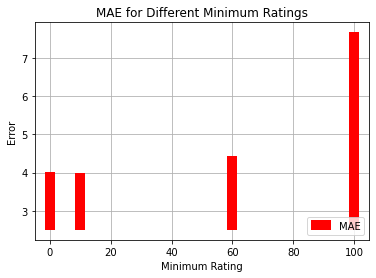

In [61]:
import matplotlib.pyplot as plt
x = [0, 10, 60, 100]
mae = [4.012636426091194, 3.9983141899108885, 4.425096625089646, 7.671800601482391]
rmse = [4.725825592884201, 4.537728760679054, 4.995821837909834, 8.038321883551674]

plt.vlines(x, 3, rmse, colors='blue', linewidth=10, label='RMSE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('RMSE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.vlines(x, 2.5, mae, colors='red', linewidth=10, label='MAE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('MAE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [73]:
# Save the trained model to a file
model.save('tournesol_model_v1')

In [95]:
#load the model .npz
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.01)
model.load("tournesol_model_v1.npz")